In [165]:
import numpy as np
from tools import *
from fitters import *
from plots import *
from projectors import *
set_seaborn({'figure.figsize': (12,8)})
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
def test_run(n_series=6, series_rank=3, dim=5, dt=0.1,  e_s=None, a_s=None, noise=1e-7, beta=1e-4, window_factor=2.0, method='', iteration=0):


    shape = (n_series, series_rank)
    if a_s is None:
        a_s = np.random.randn(*shape)
    if e_s is None:
        e_s = np.random.uniform(-2,2, size=series_rank)

    start_end = (-1, 3)
    time = np.arange(start_end[0], start_end[1]+dt, dt)
    X_series_s, Y_series_s = [], []

    for i in range(n_series):
        X_series, Y_series, _, _ = build_exp_series(
            a_s[i], e_s, noise=noise, time=time)
        if len(X_series_s) > 0:
            shift = X_series_s[-1][-1]-X_series[0]
            # X_series += shift

        X_series = X_series[1:]
        Y_series = Y_series[1:]
        X_series_s.append(X_series)
        Y_series_s.append(Y_series)

    X_series = np.concatenate(X_series_s)
    Y_series = np.concatenate(Y_series_s)

    window_factor = int(len(time)*1.5/dim)+1

    if method == 'win_noc':
        P_series, theta = eig_companion_time(X_series, dim, beta=beta, window_factor=window_factor)
    if method == 'win_c':
        P_series, theta = eig_companion_Cshift_time(X_series, dim, beta=beta, window_factor=window_factor)
    if method == 'nowin_noc':
        P_series, theta, A = eig_companion(X_series, dim, beta=beta)

  
    fit_Y = Y_series[dim:]
    Fit_series = solve_scale_shift(P_series, fit_Y)
    err = mean_square_error(Fit_series, fit_Y)


    result = {
        'Y_series': fit_Y,
        'P_series': Fit_series,
        'MSE': err,
        'theta': theta,
        'top_e': e_s[np.argmax(np.abs(e_s))]
    }

    return result


In [167]:
dims = [4,8,16]
iterations = np.arange(50)
params = {
    # 'dt': [0.05],
    'noise': [1e-2, 1e-6],
    # 'e_s': np.array([[1.5, 1.0, -0.8]]),
    'beta': [1e-8],
    'method': ['win_c', 'nowin_noc'],
    'dim': dims,
    'iteration': iterations,
}
results = param_runner(test_run, params)


[None,
 Text(0.5, 1.0, 'Error vs Dimension')]

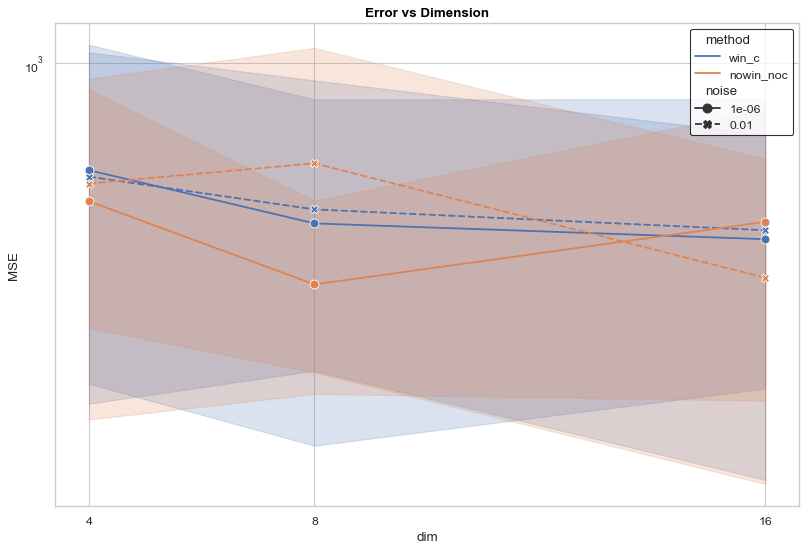

In [168]:
lp = sns.lineplot(x ='dim', y ='MSE', hue='method', style='noise', markers=True, data=results)
lp.set(yscale='log', xticks=dims, title='Error vs Dimension')